# JHU covid-19 data analysis

Recreate nytimes plot of world map: https://www.nytimes.com/interactive/2020/world/coronavirus-maps.html?action=click&module=Top%20Stories&pgtype=Homepage  
- is it really an imformative map?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import geopandas as gpd

import glob
import os
 
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 

from datetime import timedelta 

import os
import sys
base_path = os.path.abspath(os.path.join( os.getcwd()   , os.pardir ) ) 
sys.path.append(base_path ) 
import JHU_dataprocessing_functions as dp
import JHU_plotting_functions as jp

# general parameters 

In [2]:
full_w = (12,7)
half_w = (6,4)

# load JHU data

In [3]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_time_series'
file_list = ['\\time_series_covid19_confirmed_global.csv',
         '\\time_series_covid19_deaths_global.csv',
         '\\time_series_covid19_recovered_global.csv'] 

df_country = dp.merge_countrydf(path, file_list)  

# load world dataset

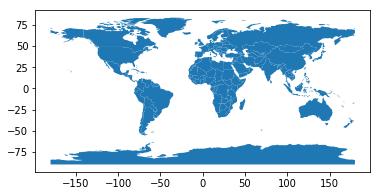

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot();

# convert geopandas data names to match JHU data

In [6]:
countries_w = world['name'].tolist()
countries_c = df_country['Country/Region'].unique().tolist()
 
conversion_dict = {'United States': 'US',
                   'Taiwan': 'Taiwan*',
                   'Czech Rep.':'Czechia',
                   'Korea':'Korea, South',
                   'Dem. Rep. Korea': 'Korea, North',
                  'Dominican Rep.':'Dominican Republic' } 
          
world['name'] = world['name'].map(conversion_dict).fillna(world['name'])

 

# data analysis to synthesise plotting variable

In [7]:
world['Cases'] = 0 
countries = world['name'].tolist()
 
dates = df_country['Date'].unique() 

for country in countries: 
    bool_country = df_country['Country/Region'] == country 
    bool_date = df_country['Date'] == dates[-1]
    bool_prior = df_country['Date'] == dates[-7] 
    if (bool_country & bool_date).sum() > 0:
        now_cases = df_country[bool_country & bool_date ]['Confirmed'].iloc[0]
        prior_cases = df_country[bool_country & bool_prior ]['Confirmed'].iloc[0]
        latest_cases = (now_cases-prior_cases)/7
    else:
        latest_cases = 0 
    
    bool_world = world['name'] == country  
    world.loc[bool_world,'Cases'] = np.log(latest_cases+1) 

 # plot world map

Text(-161, -57, 'Updated 2020-04-13')

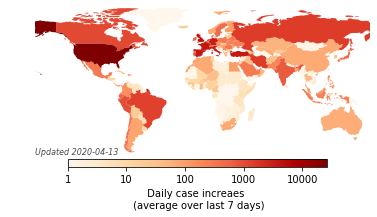

In [8]:
# fig, ax = plt.subplots(1,1 ,figsize=(15,8))
fig, ax = plt.subplots(1,1 ,figsize=half_w)

wp = world.plot(column='Cases', ax=ax, cmap='OrRd' );

wp.set_xbound(-161,161)
wp.set_ybound(-57,85) 

vmin =   world['Cases'].min()  
vmax =  world['Cases'].max() 
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))

 
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cax = fig.add_axes([0.2, 0.2, 0.6, 0.03])
cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
 
tick_array =  [1,10,100,1000,10000, 50000 ] 
log_cases = np.log( tick_array  )  
cb.set_ticks( log_cases ) 
cb.set_ticklabels( tick_array) 
cb.set_label(' Daily case increaes  \n (average over last 7 days)')
 
ax.axis("off")

ax.annotate('Updated '+str( df_country['Date'].iloc[-1]), 
            [-161,-57], color=[.3,.3,.3], style='italic',fontsize=8)
 